## Reccomendation System

### Todo: 
- Analyze the current system, look for improvements

### - Why is the model not converging?

The model is not converging because the target value(rating) has a large spread of values which result in large error gradient value which in turn causing weight values to vary or change drastically which is making the learning process unstable. 

In order to get rid of the above issue, the target value(rating) should be normalized first and the output should be between 0 and 1 as we are using sigmoid activation function for final prediction. After prediction, we can make use of inverse_transform to get the original values.


### - Improve the model and discuss your thoughts

There is an overfitting problem. In order to improve the model, regularization and dropout techniques can be used. 



In [56]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [57]:
TRAIN_SPLIT = 0.8
EMBEDDING_SIZE = 50
LOSS_FN = tf.keras.losses.BinaryCrossentropy()
OPTIMIZER = keras.optimizers.Adam(lr=0.001)

C:\Users\parm0\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# Data Visualization

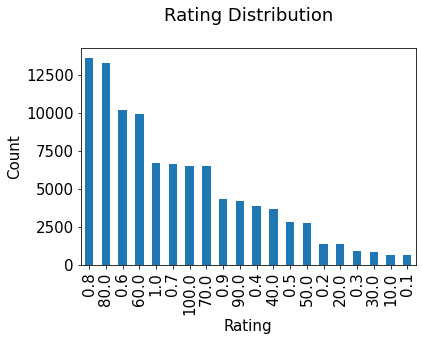

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [61]:
from sklearn.preprocessing import MinMaxScaler

#parse data into dataset
ratings = pd.read_csv("data/ratings.csv")
rating=ratings[['rating']]

#Rating Distribution visualization before scaling
plt.rc('font',size=15)
ratings.rating.value_counts(sort=True).plot(kind="bar")
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

#check if there is any null value
ratings.isnull().any()

In [62]:
'''
Using MinMax normalization to normalize rating scale and get the values between 0 and 1 
as we are using sigmoid function for final prediction
'''
scaler = MinMaxScaler()
scaled_ratings_array = scaler.fit_transform(rating) # s is scaled ratings numpy array
ratings_df = pd.DataFrame(scaled_ratings_array,columns = ['rating_scaled']) 
ratings = pd.concat([ratings, ratings_df], axis=1)
ratings.head()

   userId  movieId  rating  timestamp  rating_scaled
0       1        1     0.8  964982703       0.007007
1       1        3    80.0  964981247       0.799800
2       1        6     0.8  964982224       0.007007
3       1       47     1.0  964983815       0.009009
4       1       50   100.0  964982931       1.000000


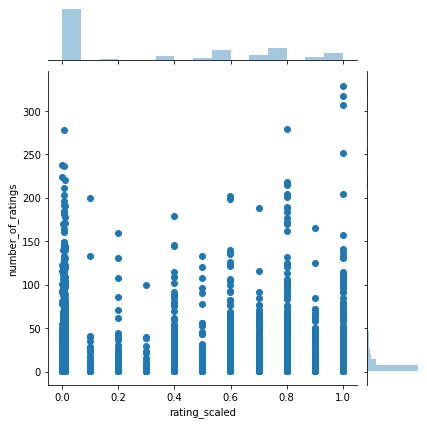

In [63]:
#creating number of ratings data
ratings['number_of_ratings'] = ratings.groupby('movieId')['rating_scaled'].count()

ratings.head()
# #Plotting the jointplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.jointplot(x='rating_scaled', y='number_of_ratings', data=ratings)

In [65]:
user_ids = ratings["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = ratings["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
ratings["user"] = ratings["userId"].map(user2user_encoded)
ratings["movie"] = ratings["movieId"].map(movie2movie_encoded)
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

ratings["rating_scaled"] = ratings["rating_scaled"].values.astype(np.float32)
x = ratings[["user", "movie"]].values
y = ratings["rating_scaled"].values

train_indices = int(TRAIN_SPLIT * ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


In [66]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(80668, 2)
(20168, 2)
(80668,)
(20168,)


In [67]:
class NeuralNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(NeuralNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


In [68]:
nn_model = NeuralNet(num_users, num_movies, EMBEDDING_SIZE)
nn_model.compile(
    loss=LOSS_FN, optimizer=OPTIMIZER
)
history = nn_model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/50
1261/1261 [==============================] - 15s 10ms/step - loss: 0.6705 - val_loss: 0.7009
Epoch 2/50
1261/1261 [==============================] - 13s 10ms/step - loss: 0.6481 - val_loss: 0.7015
Epoch 3/50
1261/1261 [==============================] - 13s 10ms/step - loss: 0.6444 - val_loss: 0.7036
Epoch 4/50
1261/1261 [==============================] - 13s 10ms/step - loss: 0.6442 - val_loss: 0.7047
Epoch 5/50
1261/1261 [==============================] - 12s 10ms/step - loss: 0.6445 - val_loss: 0.7074
Epoch 6/50
1261/1261 [==============================] - 13s 10ms/step - loss: 0.6439 - val_loss: 0.7070
Epoch 7/50
1261/1261 [==============================] - 13s 10ms/step - loss: 0.6434 - val_loss: 0.7096
Epoch 8/50
1261/1261 [==============================] - 12s 10ms/step - loss: 0.6412 - val_loss: 0.7111
Epoch 9/50
1261/1261 [==============================] - 13s 10ms/step - loss: 0.6405 - val_loss: 0.7126
Epoch 10/50
1261/1261 [==============================] - 13s 10m

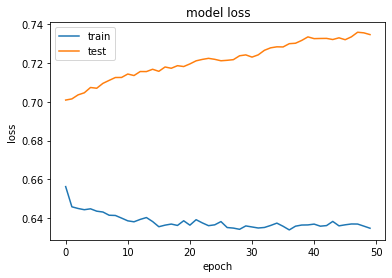

In [84]:
#Plot training and validation loss
#Observation : there is an overfiting issue. 
#In order to get rid of this problem we can apply regularization or dropout technique.

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Tried to improve model


In [85]:
NUM_USERS = ratings['userId'].nunique()
NUM_MOVIES = ratings['movieId'].nunique()
train, test = train_test_split(ratings, test_size=0.2)

In [101]:
EMBEDDING_SIZE=10
ROW_COUNT=train.shape[0]

### Used dense layer along with dropout(randomly dropped 25% of units after second dense layer)
### Used sigmoid function to force values between 0 and 1. the scaled rating values also exist between 0 and 1
### Tried to finetune hyperparameters as well like changed embedding size, loss function and optimizer
#### tried used SGD(Stochastic Gradient Descent) Optimizer. it converge faster and performs updates more frequently

movie_input = keras.Input(shape=(1,), name='movieId')
movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)

user_input = keras.Input(shape=(1,), name='userId')
user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)

merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
dense_1 = layers.Dense(60,name='FullyConnected-1')(merged)
dense_2 = layers.Dense(20,name='FullyConnected-2')(dense_1)
dropout_2 = layers.Dropout(0.25)(dense_2)

# The sigmoid activation forces the rating to between 0 and 1
result = layers.Dense(1, name='result', activation="sigmoid") (dense_2)
sgd = keras.optimizers.SGD(learning_rate=0.002)

loss_fn = keras.losses.MeanAbsoluteError()

model = keras.Model([movie_input, user_input], result)
model.compile(optimizer=sgd,loss=loss_fn)


In [98]:
model.summary()

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movieId (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
userId (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 10)        97240       movieId[0][0]                    
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 10)        6100        userId[0][0]                     
___________________________________________________________________________________________

In [99]:
#only best model will be saved with early stopping(if the model stop improving noticiiable then after observing 10 epochs then the training will be stopped)
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('bestmodel.h5', save_best_only=True)]

#trained for 100 epochs and batch size is 100
history = model.fit([train.movie, train.user],train.rating_scaled, batch_size=100,
                              epochs =100, validation_data = ([test.movie, test.user],test.rating_scaled),
                              verbose = 1,
                              callbacks = callbacks)

Epoch 1/100
807/807 [==============================] - 4s 3ms/step - loss: 0.3708 - val_loss: 0.3622
Epoch 2/100
807/807 [==============================] - 2s 2ms/step - loss: 0.3598 - val_loss: 0.3570
Epoch 3/100
807/807 [==============================] - 2s 2ms/step - loss: 0.3559 - val_loss: 0.3544
Epoch 4/100
807/807 [==============================] - 2s 2ms/step - loss: 0.3533 - val_loss: 0.3522
Epoch 5/100
807/807 [==============================] - 2s 2ms/step - loss: 0.3509 - val_loss: 0.3507
Epoch 6/100
807/807 [==============================] - 2s 2ms/step - loss: 0.3498 - val_loss: 0.3495
Epoch 7/100
807/807 [==============================] - 2s 2ms/step - loss: 0.3489 - val_loss: 0.3484
Epoch 8/100
807/807 [==============================] - 2s 2ms/step - loss: 0.3483 - val_loss: 0.3475
Epoch 9/100
807/807 [==============================] - 2s 2ms/step - loss: 0.3478 - val_loss: 0.3469
Epoch 10/100
807/807 [==============================] - 2s 2ms/step - loss: 0.3460 - val_lo

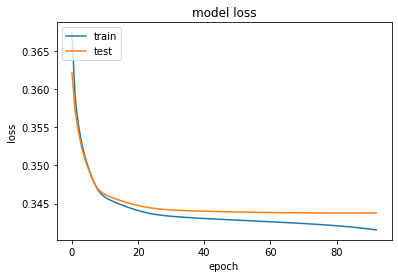

In [100]:
#Plot training and validation loss of improved model

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()